In [1]:
library(tidyverse) |> suppressMessages()
library(repr) |> suppressMessages()
library(tidymodels) |> suppressMessages()
library(cowplot) |> suppressMessages()
library(GGally) |> suppressMessages()
options(repr.matrix.max.rows = 6)
#source('tests.R')
#source("cleanup.R")

set.seed(1234)

# Prediction to the risk of heart attack 

## INTRODUCTION

## METHODS AND RESULTS

#### Reading the data

Firstly, we read the data from our github repository using `read_csv` function. Beforehand, we decided to download the original data from UCI machine learning repository and move it into our github repository for the sake of accessibility. 

In [2]:
heart_attack_data_raw = read_delim("https://raw.githubusercontent.com/RichardAdhika22/group115/main/processed.hungarian%20(1).data",delim=","
                                ,col_names=FALSE) |> suppressMessages()

heart_attack_data_raw

X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14
<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<dbl>
28,1,2,130,132,0,2,185,0,0,?,?,?,0
29,1,2,120,243,0,0,160,0,0,?,?,?,0
29,1,2,140,?,0,0,170,0,0,?,?,?,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
56,1,4,155,342,1,0,150,1,3,2,?,?,1
58,0,2,180,393,0,0,110,1,1,2,?,7,1
65,1,4,130,275,0,1,115,1,1,2,?,?,1


#### Cleaning and tidying the data

The dataframe above does not have any column name, so we can add the column's name referring to the information given for each column from the UCI machine learning repository. Furthermore, there are some missing data, which is marked by the "?" in the table. Therefore, we also remove all of the missing data. Last but not least, we change the data type for "sex" and "num" from double to factor, so that we can do classification on the variable "num" (classification can only be done on a factor type variable).

In [3]:
colnames(heart_attack_data_raw) = c('age','sex','cp','trestbps','chol','fbs','restecg','thalach','exang','oldpeak','slope','ca','thal','num')
heart_attack_data_tidy = select(heart_attack_data_raw,-slope,-ca,-thal)
heart_attack_data_tidy = filter_all(heart_attack_data_tidy,all_vars(.!="?"))
heart_attack_data_tidy = mutate_if(heart_attack_data_tidy, is.character,as.numeric) |> mutate(num = as.factor(num)) |> mutate(sex = as.factor(sex))

heart_attack_data_tidy


age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,num
<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
28,1,2,130,132,0,2,185,0,0,0
29,1,2,120,243,0,0,160,0,0,0
30,0,1,170,237,0,1,170,0,0,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
56,1,4,155,342,1,0,150,1,3,1
58,0,2,180,393,0,0,110,1,1,1
65,1,4,130,275,0,1,115,1,1,1


#### Splitting the data into training and testing set

As a rule of thumb, we should always split our data into training set and testing set when doing a prediction. All of the exploratory analysis and model below will only be built based on the training data. For the testing data, we will only use it to evaluate the accuracy of our prediction and summarize how well our prediction do. Furthermore, we also set the seed to some value so that our prediction model will be reproducible. Lastly, we use 75 percent of our original dataset as our training data using `prop=0.75`.

In [4]:
heart_attack_split = initial_split(heart_attack_data_tidy, prop = 0.75, strata = num)
heart_attack_training = training(heart_attack_split)
heart_attack_testing = testing(heart_attack_split)

heart_attack_training
heart_attack_testing

age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,num
<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
29,1,2,120,243,0,0,160,0,0,0
30,0,1,170,237,0,1,170,0,0,0
31,0,2,100,219,0,1,150,0,0,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
56,1,4,155,342,1,0,150,1,3,1
58,0,2,180,393,0,0,110,1,1,1
65,1,4,130,275,0,1,115,1,1,1


age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,num
<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
28,1,2,130,132,0,2,185,0,0,0
32,0,2,105,198,0,0,165,0,0,0
32,1,2,125,254,0,0,155,0,0,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
59,1,4,140,264,1,2,119,1,0,1
50,1,4,140,231,0,1,140,1,5,1
52,1,4,140,266,0,0,134,1,2,1


#### Selecting only the data used in the prediction

Here, we choose 5 variables as our predictors as follow: age, trestbps, chol, thalach, oldpeak, num. The reason is because these 5 variables come in the double type, which will be more accurate to use in our prediction compared to the rest (Based on the table above, other variables also come in double type, but they are actually supposed to be factor type).

In [5]:
heart_attack_data_selected = heart_attack_training |>
    select(age,trestbps,chol,thalach,oldpeak,num)

heart_attack_data_selected

age,trestbps,chol,thalach,oldpeak,num
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
29,120,243,160,0,0
30,170,237,170,0,0
31,100,219,150,0,0
⋮,⋮,⋮,⋮,⋮,⋮
56,155,342,150,3,1
58,180,393,110,1,1
65,130,275,115,1,1


####  Examining the distribution of the prediction target class

Here, we are going to look at the distibution of the prediction target class by calculating the precentage of each class.  In addition, we are also going to plot in a histogram to visualize the distribution.

In [6]:
total_amount = heart_attack_data_selected |>
    summarize("total"=n())|>
    pull()

table_num_count = heart_attack_data_selected |>
    group_by(num) |>
    summarize("total_number_of_num" = n())|>
    mutate("percentage" = total_number_of_num/total_amount*100)

table_num_count 

num,total_number_of_num,percentage
<fct>,<int>,<dbl>
0,122,62.5641
1,73,37.4359


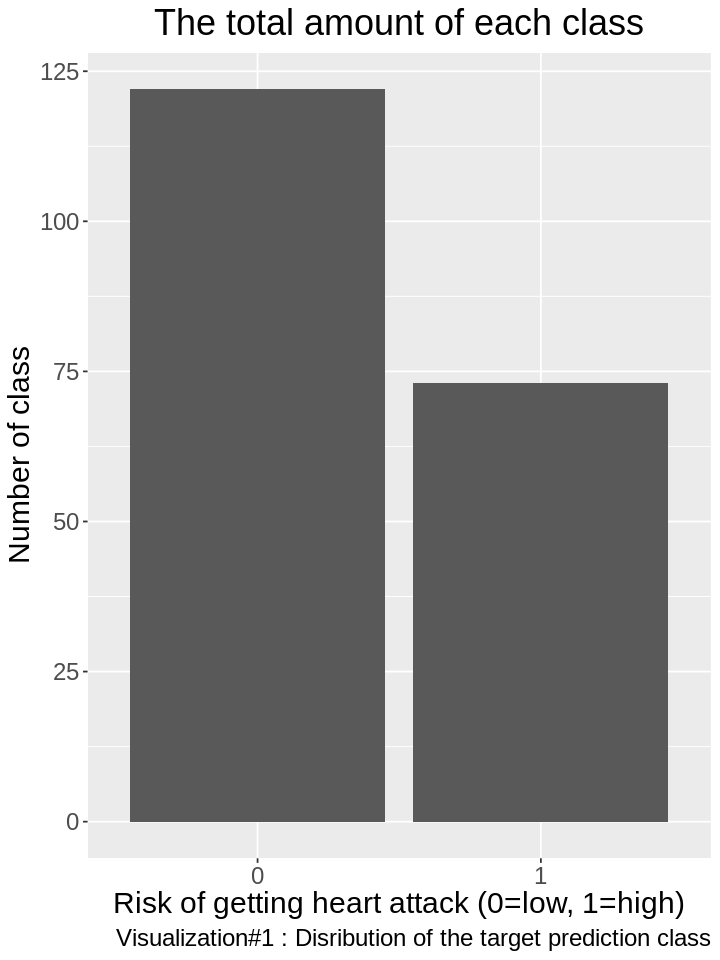

In [7]:
options(repr.plot.width=6, repr.plot.height=8)

num_count_plot = table_num_count |>
    ggplot(aes(x = num, y = total_number_of_num))+
    geom_bar(stat="identity")+
    labs(x = "Risk of getting heart attack (0=low, 1=high)", y = "Number of class",caption='Visualization#1 : Disribution of the target prediction class')+
    ggtitle("The total amount of each class")+
    theme(text = element_text(size=18), plot.title = element_text(hjust=0.5))

num_count_plot

Looking at the calculation and visualization above, we can conclude that there are more data in the low risk of getting heart attack category (around 63 percent) than the data in the high risk of getting heart attack.

#### The number of omitted observation

We are interested in finding out how many data are missing or incomplete in our original dataset. We decided to remove these data from the dataset because incomplete data (mostly missing one predictor out of 5 predictors) are very difficult to be managed and calculated in building the prediction model.

In [8]:
missing_data = nrow(heart_attack_data_raw) - nrow(heart_attack_data_tidy)
missing_data

missing_data_percentage = missing_data/nrow(heart_attack_data_raw)
missing_data_percentage

[1] 33

[1] 0.1122449

We obtain that 33 data are incomplete, whcih is roughly 11 percent of the total data. These missing data are usually caused by some technical difficulties, such as incomplete data collecting. This number of percentage is still fine because we still have a lot of data left to work with in building the prediction model. 

#### Data summary of each predictor variable

The next step is to examine the average and standard deviation of each predictor based on their category.
It is important to understand about how the data look like before proceed into building the model.
We do not make a visualization in this case because the scale of every predictor varies, so making a plot will not be useful.

In [9]:
table_means = heart_attack_data_selected |>
    group_by(num) |>
    summarize(across(age:oldpeak,.fns=list('mean'=mean,'sd'=sd)))

table_means

num,age_mean,age_sd,trestbps_mean,trestbps_sd,chol_mean,chol_sd,thalach_mean,thalach_sd,oldpeak_mean,oldpeak_sd
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,47.34426,7.881111,130.4918,16.99453,239.0820,52.13945,146.2049,21.57667,0.1967213,0.4834337
1,48.61644,7.202681,134.4384,17.89397,266.6438,77.81270,130.3014,23.83432,1.2260274,1.0241565


#### Distribution of each predictor variable

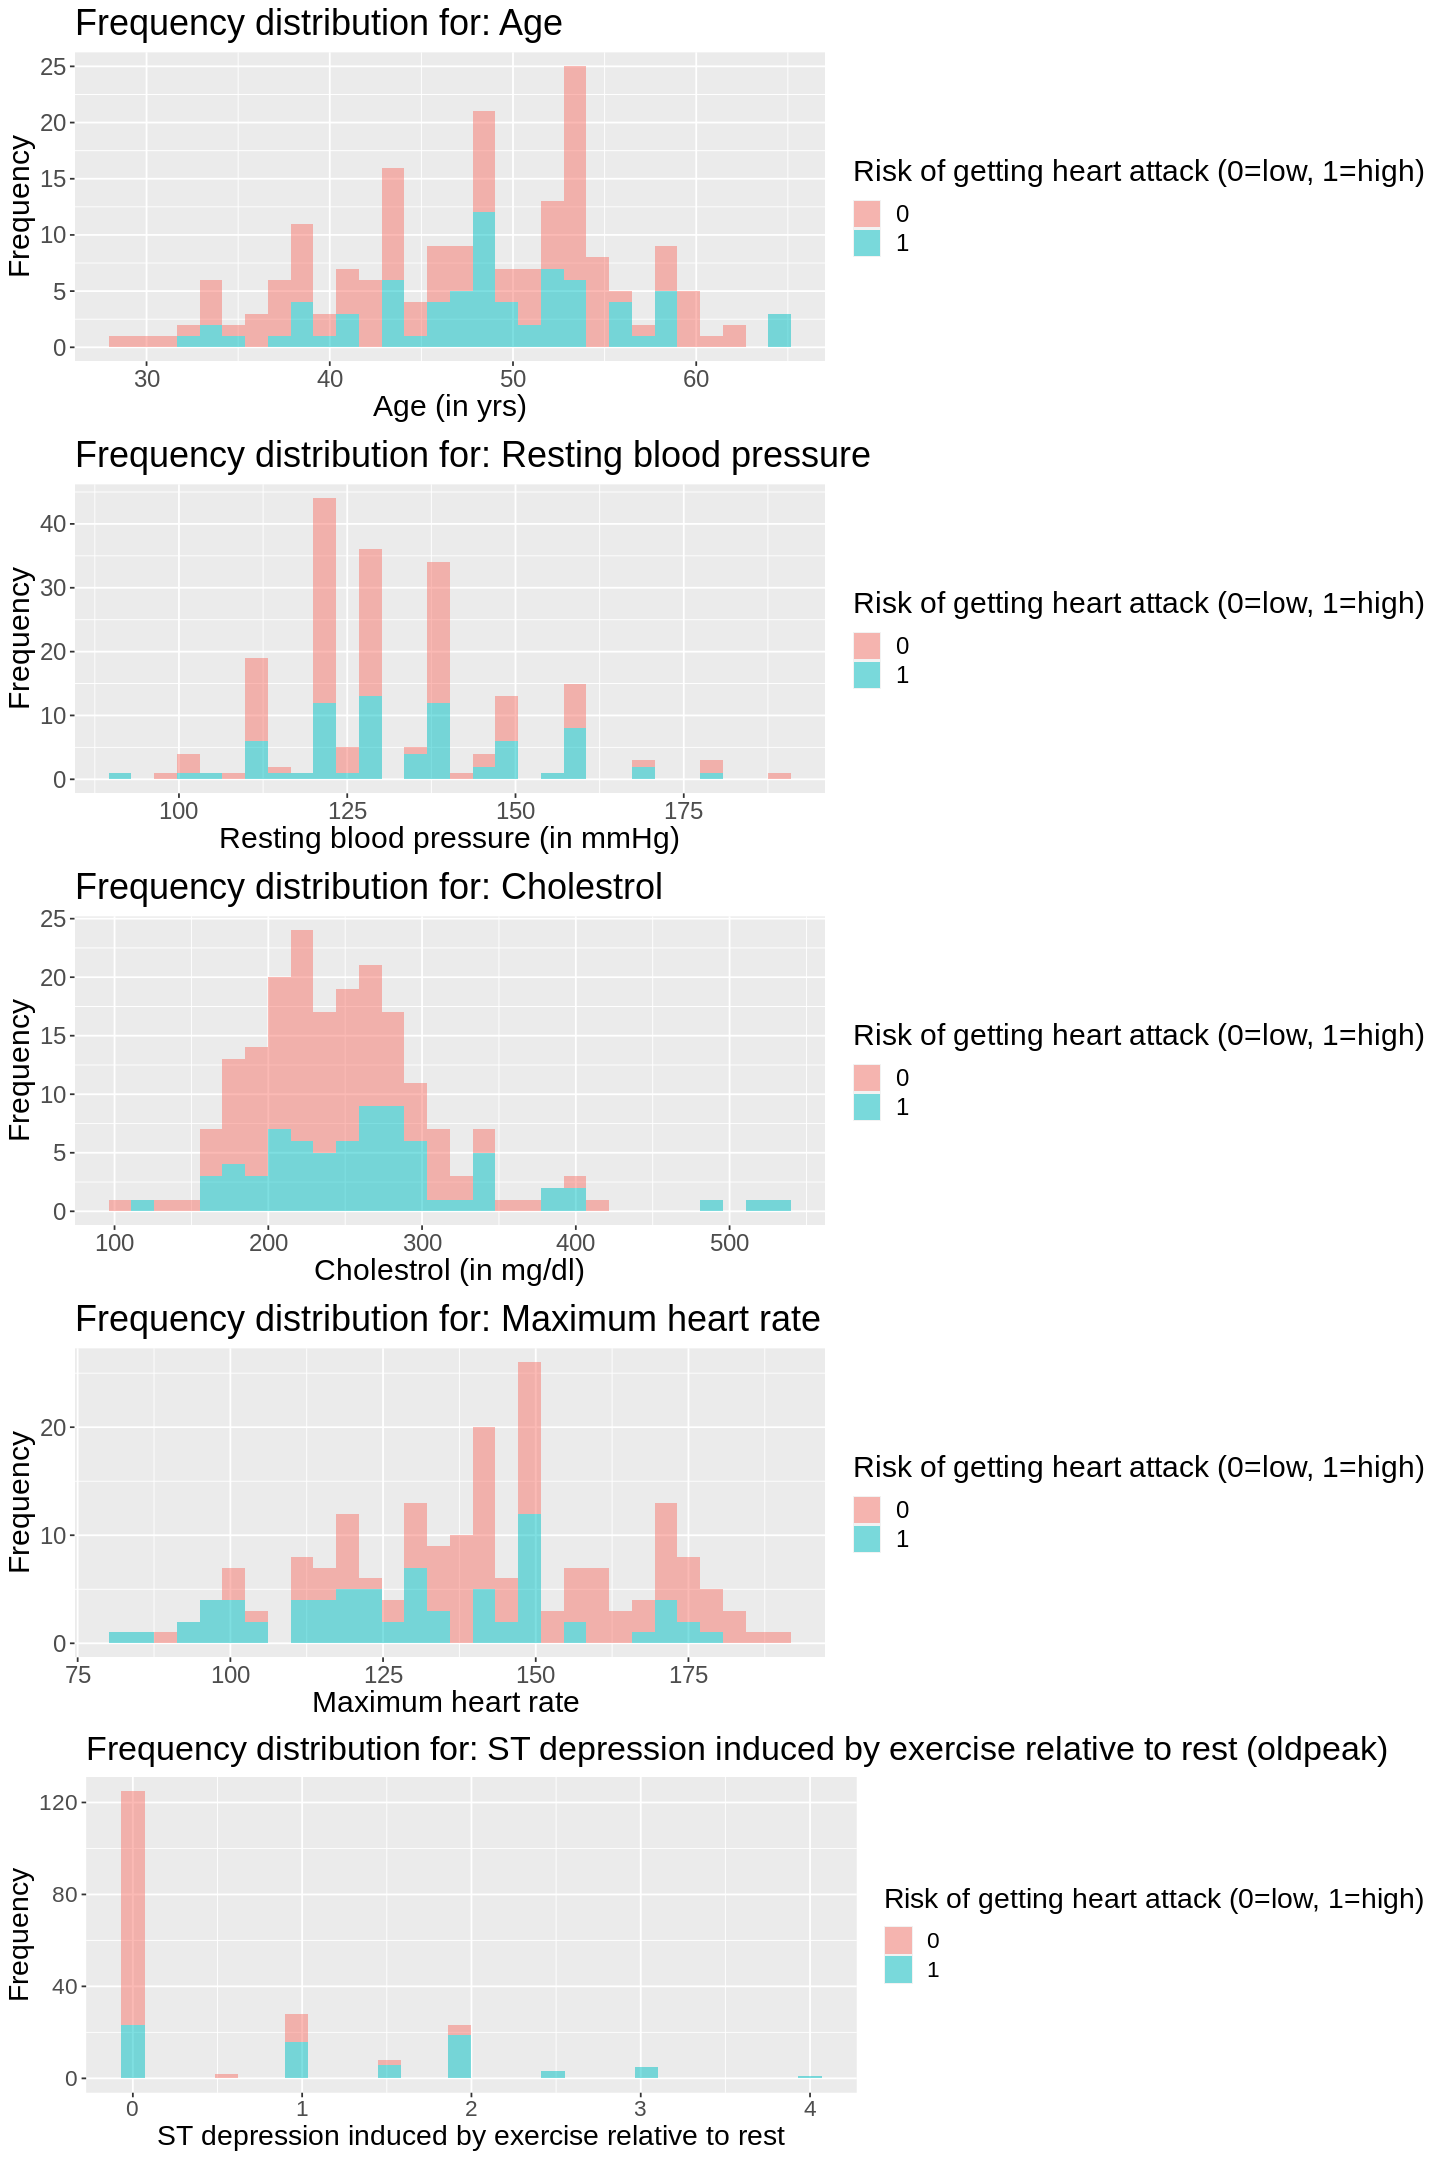

In [10]:
options(repr.plot.width=12, repr.plot.height=18)

age_hist = heart_attack_data_selected |>
    ggplot(aes(x=age, fill=num))+
    geom_histogram(alpha=0.5,bins = 30)+
    labs(x = "Age (in yrs)", y = "Frequency", fill = "Risk of getting heart attack (0=low, 1=high)")+
    ggtitle("Frequency distribution for: Age")+
    theme(text = element_text(size=18))

trestbps_hist = heart_attack_data_selected |>
    ggplot(aes(x=trestbps, fill=num))+
    geom_histogram(alpha=0.5,bins = 30)+
    labs(x = "Resting blood pressure (in mmHg)", y = "Frequency", fill = "Risk of getting heart attack (0=low, 1=high)")+
    ggtitle("Frequency distribution for: Resting blood pressure")+
    theme(text = element_text(size=18))

chol_hist = heart_attack_data_selected |>
    ggplot(aes(x=chol, fill=num))+
    geom_histogram(alpha=0.5,bins = 30)+
    labs(x = "Cholestrol (in mg/dl)", y = "Frequency", fill = "Risk of getting heart attack (0=low, 1=high)")+
    ggtitle("Frequency distribution for: Cholestrol")+
    theme(text = element_text(size=18))

thalach_hist = heart_attack_data_selected |>
    ggplot(aes(x=thalach, fill=num))+
    geom_histogram(alpha=0.5,bins = 30)+
    labs(x = "Maximum heart rate ", y = "Frequency", fill = "Risk of getting heart attack (0=low, 1=high)")+
    ggtitle("Frequency distribution for: Maximum heart rate")+
    theme(text = element_text(size=18))

oldpeak_hist = heart_attack_data_selected |>
    ggplot(aes(x=oldpeak, fill=num))+
    geom_histogram(alpha=0.5,bins = 30)+
    labs(x = "ST depression induced by exercise relative to rest", y = "Frequency", fill = "Risk of getting heart attack (0=low, 1=high)")+
    ggtitle("Frequency distribution for: ST depression induced by exercise relative to rest (oldpeak)")+
    theme(text = element_text(size=17))

plot_grid(age_hist, trestbps_hist, chol_hist, thalach_hist, oldpeak_hist, ncol=1)

#### Relationship between predictors

By using the `ggpairs()` function, we are going to examine the relationshiop between 5 predictors that we are going to use in building the prediction model. 

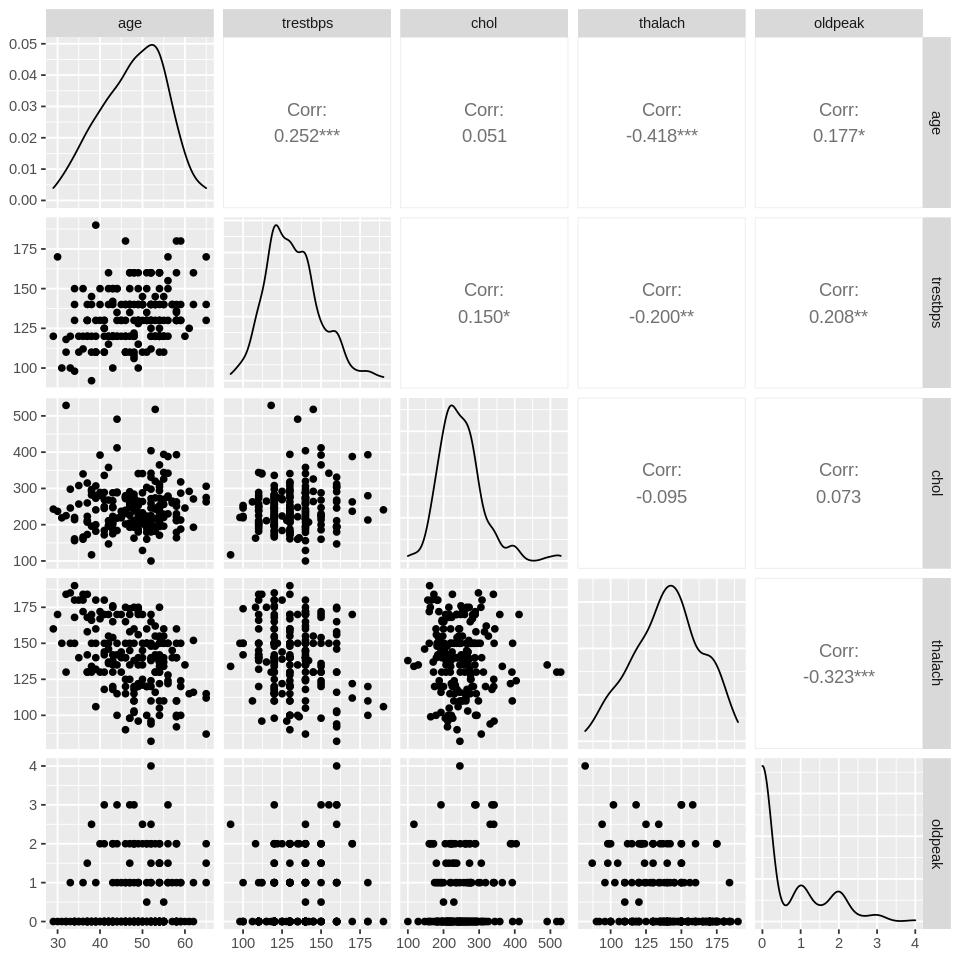

In [11]:
options(repr.plot.width = 8, repr.plot.height = 8)

heart_attack_relationships = heart_attack_data_selected |>
    select(-num)|>
    ggpairs()

heart_attack_relationships

#### Scaling and Centering the variables

In our case, the spread and mean of each variable that we use to predict the target class vary. Therefore, we have to scale and center each value of the predictors so that every predictor will weight the same when calculating the euclidean distnace.

In [12]:
heart_attack_recipe = recipe(num ~., data = heart_attack_data_selected)|>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

heart_attack_recipe

Recipe

Inputs:

      role #variables
   outcome          1
 predictor          5

Operations:

Scaling for all_predictors()
Centering for all_predictors()

Below, we are going to use cross-validation method. 

In [13]:
heart_attack_vfold = vfold_cv(heart_attack_data_selected, v = 5, strata = num)

In [14]:
heart_attack_spec = nearest_neighbor(weight_func = "rectangular", neighbors = tune())|>
    set_engine("kknn")|>
    set_mode("classification")
    
heart_attack_spec

K-Nearest Neighbor Model Specification (classification)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


In [15]:
k_values = tibble(neighbors = seq(1,30))

heart_attack_workflow = workflow()|>
    add_recipe(heart_attack_recipe)|>
    add_model(heart_attack_spec)|>
    tune_grid(resamples = heart_attack_vfold, grid = k_values)

In [16]:
heart_attack_accuracies = heart_attack_workflow |>
    collect_metrics() |>
    filter(.metric == "accuracy")

heart_attack_accuracies

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.6714912,5,0.02966741,Preprocessor1_Model01
2,accuracy,binary,0.6714912,5,0.02966741,Preprocessor1_Model02
3,accuracy,binary,0.7228138,5,0.03423249,Preprocessor1_Model03
⋮,⋮,⋮,⋮,⋮,⋮,⋮
28,accuracy,binary,0.7737247,5,0.02715271,Preprocessor1_Model28
29,accuracy,binary,0.7737247,5,0.02715271,Preprocessor1_Model29
30,accuracy,binary,0.7737247,5,0.02715271,Preprocessor1_Model30


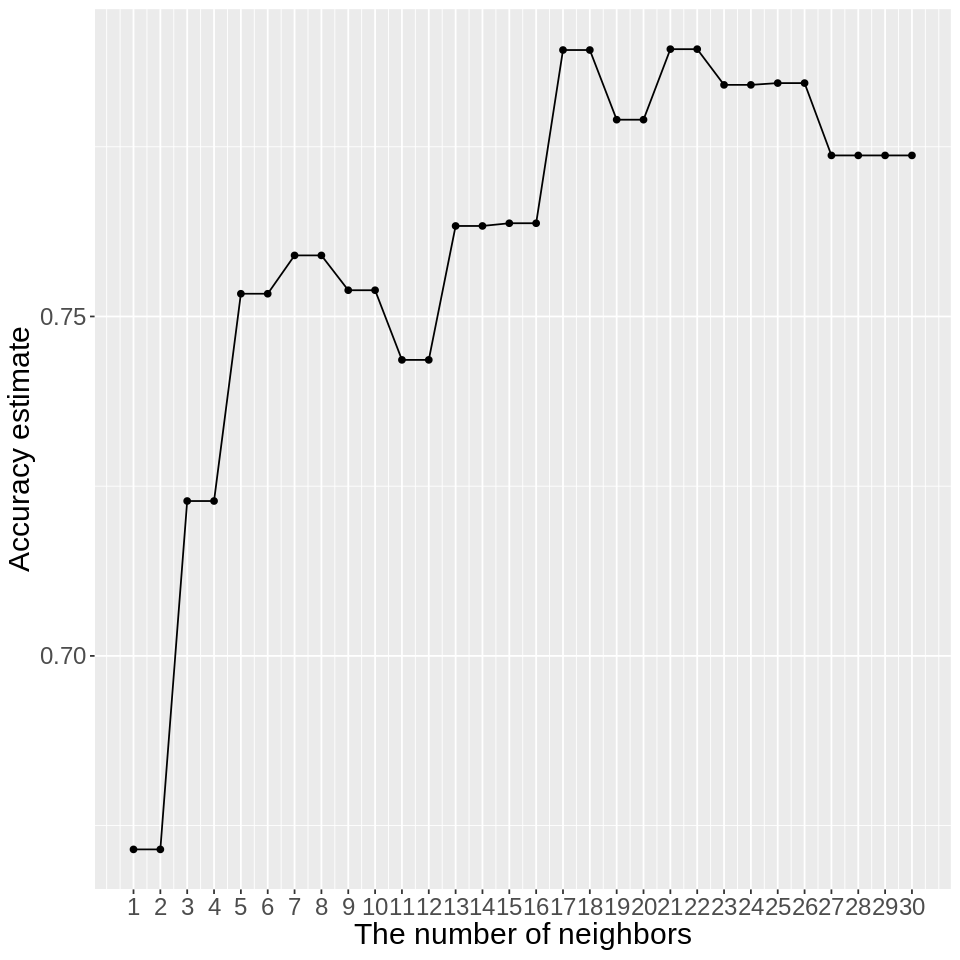

In [17]:
options(repr.plot.width = 8, repr.plot.height = 8)

heart_attack_accuracies_plot = heart_attack_accuracies |>
    ggplot(aes(x = neighbors, y = mean))+
    geom_line()+
    geom_point()+
    labs(x = "The number of neighbors", y = "Accuracy estimate")+
    scale_x_continuous(breaks = seq(1,30, by = 1))+
    theme(text = element_text(size = 18))

heart_attack_accuracies_plot

In [18]:
k_max_value = heart_attack_accuracies |>
    arrange(desc(mean))|>
    slice(1)|>
    select(neighbors)|>
    pull()

k_max_value

[1] 21

In [19]:
heart_attack_spec_final = nearest_neighbor(weight_func = "rectangular", neighbors = k_max_value)|>
    set_engine("kknn")|>
    set_mode("classification")

heart_attack_spec_final

K-Nearest Neighbor Model Specification (classification)

Main Arguments:
  neighbors = k_max_value
  weight_func = rectangular

Computational engine: kknn 


In [20]:
heart_attack_result = workflow()|>
    add_recipe(heart_attack_recipe)|>
    add_model(heart_attack_spec_final)|>
    fit(heart_attack_data_selected)

heart_attack_result

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(21L,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.2102564
Best kernel: rectangular
Best k: 21

In [21]:
heart_attack_prediction = heart_attack_result |>
    predict(heart_attack_testing)|>
    bind_cols(heart_attack_testing)

heart_attack_final_accuracy = heart_attack_prediction |>
    metrics(truth = num, estimate = .pred_class)|>
    filter(.metric == "accuracy")

heart_attack_prediction
heart_attack_final_accuracy

.pred_class,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,num
<fct>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
0,28,1,2,130,132,0,2,185,0,0,0
0,32,0,2,105,198,0,0,165,0,0,0
0,32,1,2,125,254,0,0,155,0,0,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
0,59,1,4,140,264,1,2,119,1,0,1
1,50,1,4,140,231,0,1,140,1,5,1
1,52,1,4,140,266,0,0,134,1,2,1


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.7878788


In [22]:
heart_attack_mnist = heart_attack_prediction |>
    conf_mat(truth = num, estimate = .pred_class)

heart_attack_mnist

          Truth
Prediction  0  1
         0 36  9
         1  5 16